In [1]:
import numpy as np
import scipy.stats as spstat
from dataclasses import dataclass
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.optimize import fsolve

T = 0.01


from joblib import Parallel, delayed

In [2]:
# Class for the CANN model

class cann_model:
    # define the range of perferred stimuli
    z_min = - np.pi;              
    z_range = 2.0 * np.pi;
    # define the time scale
    tau = 2.0
        
    # function for periodic boundary condition
    def dist(self, c):
        tmp = np.remainder(c, self.z_range)
        
        # routine for numbers
        if isinstance(tmp, (int, float)):
            if tmp > (0.5 * self.z_range):
                return (tmp - self.z_range);
            return tmp;
        
        # routine for numpy arraies
        for tmp_1 in np.nditer(tmp, op_flags=['readwrite']):
            if tmp_1 > (0.5 * self.z_range):
                tmp_1[...] = tmp_1 - self.z_range;
        
        return tmp;
    
    # constructor (?)
    def __init__(self, argument):
        self.k = argument.k;              # rescaled inhibition
        self.beta = argument.beta;        # rescaled STD
        self.beta_f = argument.beta_f;        
        self.case = argument.case
        self.taud = argument.taud;        # rescaled STD timescale
        self.a = argument.a;              # range of excitatory connection
        self.N = argument.N;              # number of units / neurons
        self.dx = self.z_range / self.N     # separation between neurons
        
        # define perferred stimuli for each neuron
        self.x = (np.arange(0,self.N,1)+0.5) * self.dx + self.z_min;
        
        # difference of x's
        self.x_diff = np.array(
                       [[self.dist(self.x[i] - self.x[j]) 
                         for j in range(self.x.shape[0])]
                        for i in range(self.x.shape[0])]
                       )
        
        # calculate the excitatory couple for each pair of neurons
        self.Jxx = np.exp(-0.5 * np.square(
                      self.x_diff / self.a
                   ) ) / (np.sqrt(2*np.pi) * self.a);
                
        self.y = np.zeros((self.N + self.N * self.N));   # initialize dynamical variables
        self.y[self.N:] = 1.0
        
        self.beta = np.zeros_like(self.x_diff)

        for i in np.arange(self.Jxx.shape[1]):

            local_x = np.abs(self.x_diff[:,i])

            x_max = np.max(local_x) + (self.z_range/self.N) / 2.0
            x_min = np.min(local_x) - (self.z_range/self.N) / 2.0

            ps = (x_max - local_x) / (x_max - x_min)

            if self.case > 0:
                gamma_randm = spstat.gamma.ppf(ps, 3.354520641938138)*9.743699331037247
            else:
                gamma_randm = spstat.gamma.ppf(ps, 1.377771974410986)*29.196273404252505

            self.beta[:,i] = gamma_randm.transpose()

        self.beta *= argument.beta / np.mean(self.beta)
        
        if argument.beta_f:
            self.beta = np.ones_like(self.Jxx) * argument.beta
        
# Defining a class of input arguments as a workaround 
# for the argparse

@dataclass()
class argument_c:
    k:float
    beta:float
    beta_f:bool
    case:int
    taud:float
    a:float
    N:int
    
    def _init__(self, N, k, beta, beta_f, case, taud, a):
        self.N = N
        self.k = k
        self.beta = beta
        self.beta_f = beta_f
        self.case = case
        self.taud = taud
        self.a = a
    

In [3]:
def F(x:np.ndarray, the_model):
    
    u0 = x[0]
    p0 = x[1]
    s0 = x[2]
    
    arg_dummy = argument_c(N=the_model.N, k=the_model.k, beta=1, beta_f = the_model.beta_f, 
                           case=the_model.case, taud=the_model.taud, a=0.5)
    dummy = cann_model(arg_dummy)
    
    gauss_4a = np.exp(-0.25 * np.square (the_model.dist(the_model.x - s0) / the_model.a))
    gauss_2a = np.exp(-0.5 * np.square (the_model.dist(the_model.x - s0) / the_model.a))    
    psi = dummy.beta * np.exp(-0.5 * np.square (the_model.x / the_model.a))
    dummy = None
    
    dgauss_4a_dx = np.gradient(gauss_4a, the_model.x)    
    dpsi_dx1 = np.gradient(psi, the_model.x, axis=0)    
    dpsi_dx2 = np.gradient(psi, the_model.x, axis=1)    
    
    u0_old = None
    p0_old = None
    
    for t in range(10000):
    
        rx = (u0 * u0 / (1 + 0.125 * the_model.k * u0 * u0)) * gauss_2a

        ux = u0 * gauss_4a

        pxx = 1 - p0 * psi
        
        Fu = -ux + np.dot(the_model.Jxx * pxx, rx) * the_model.dx
        
        Fp = 1 - pxx - the_model.beta * pxx * rx
        
        v = - np.sum(dgauss_4a_dx * Fu) / np.sum(dgauss_4a_dx * dgauss_4a_dx) / (1e-20 + the_model.tau * u0)
    
        u0_new = u0 + np.sum(gauss_4a * Fu) / np.sum(gauss_4a * gauss_4a)
        
        p0_new = p0 - 0.05 * np.sum(psi * Fp) / np.sum(psi * psi)
        
        Fv = np.sum((dpsi_dx1 + dpsi_dx2) * Fp) / np.sum((dpsi_dx1 + dpsi_dx2) * (dpsi_dx1 + dpsi_dx2))\
                - the_model.taud * p0 * v

        if u0_old is not None and p0_old is not None and t > 10:
            r_u0 = np.abs((u0_new - u0_old) / (1e-20 + u0_old))
            r_p0 = np.abs((p0_new - p0_old) / (1e-20 + p0_old))
            if r_u0 < 1e-4 and r_p0 < 1e-4:
                break

        u0_old = u0

        p0_old = p0
        
        u0 = u0_new
        
        p0 = p0_new
        
    return u0, p0, v, Fv, np.linalg.norm(Fu)/len(Fu), np.linalg.norm(Fp)/len(Fp)

    
def cal_D(x:np.ndarray, the_model):
    
    u0 = x[0]
    p0 = x[1]
    s  = x[2]
    v  = x[3]
    
    arg_dummy = argument_c(N=the_model.N, k=the_model.k, beta=1, beta_f = the_model.beta_f, 
                           case=the_model.case, taud=the_model.taud, a=0.5)
    dummy = cann_model(arg_dummy)

    dx = dummy.dx

    def E4(z):
        return np.exp(-0.25 * np.square (the_model.dist(the_model.x - z) / the_model.a))

    def E2(z):
        return np.exp(-0.5 * np.square (the_model.dist(the_model.x - z) / the_model.a))

    def psi(z):
        return dummy.beta * np.exp(-0.5 * np.square (the_model.dist(the_model.x - z)  / the_model.a))

    def cal_F_all(z, s):

        u = u0 * E4(z)

        p = 1 - p0 * psi(z + s)
        
        r = u0 * u0 * E2(z) / (1.0 + 0.125 * the_model.k * u0 * u0)

        Fu = (- u + np.dot(the_model.Jxx * p , r) * the_model.dx) / the_model.tau

        Fp = (1 - p - the_model.beta * p * r) / the_model.taud

        return Fu, Fp
    
    gauss_4a = E4(0)
    gauss_2a = E2(0)
    psi0 = psi(0)
    
    dgauss_4a_dx = np.gradient(gauss_4a, the_model.x)    
    dpsi_dx1 = np.gradient(psi0, the_model.x, axis=0)    
    dpsi_dx2 = np.gradient(psi0, the_model.x, axis=1)    
    
    dFuds_p1, dFpds_p1 = cal_F_all(0, 0+dx)
    dFuds_n1, dFpds_n1 = cal_F_all(0, 0-dx)

    dFuds = (dFuds_p1 - dFuds_n1) / (2. * dx)

    dFpds = (dFpds_p1 - dFpds_n1) / (2. * dx)

    Mzs = - np.sum(dgauss_4a_dx * dFuds) / (u0 * np.sum(dgauss_4a_dx * dgauss_4a_dx))

    Mss = np.sum((dpsi_dx1 + dpsi_dx2) * dFpds) / (p0 * np.sum((dpsi_dx1 + dpsi_dx2) * (dpsi_dx1 + dpsi_dx2)))  \
             + np.sum(dgauss_4a_dx * dFuds) / (u0 * np.sum(dgauss_4a_dx * dgauss_4a_dx))

    M = np.array(
        [
            [0, Mzs],
            [0, Mss]
        ]
    )

    T_tilde = T / the_model.tau**2 * np.sqrt(8.0 / np.pi) * the_model.a / (u0 * u0) 

    evals, evecs = np.linalg.eig(M)

    U = evecs

    U_inv = np.linalg.inv(U)

    D = 2.0 * T_tilde * ((U_inv[0,0] - U_inv[0,1])*U[0,0])**2

    # print(2.0 * T_tilde * ((U_inv[0,0] - U_inv[0,1])*U[0,0])**2 * 4000)



    

    return D

    
    
    


In [4]:

def one_round(k_in, beta_in):
    
    output = []
    
    for case in [0,1]:

        arg0 = argument_c(N=128, k=k_in, beta=beta_in, beta_f=False, case=case, taud=100, a=0.5)

        the_model0 = cann_model(arg0)

        s = 0
        ds = 0.1

        while ds > 1e-6:

            s = s + ds
            
            u0, p0, v, Fv, Fu, Fp = 0, 0, 0, 0, 0, 0

            u0, p0, v, Fv, Fu, Fp = F((np.sqrt(8.)*1.1/the_model0.k, 0, s), the_model0)

            # print("{:.5f} {:.5f} {:.5f} v={:.5f} {:.5f} {:.5f} {:.5f}".format(ds, u0, p0, v, Fv, Fu, Fp))
            # u0, p0, v, Fv = 0, 0, 0, 0

            # u0, p0, v, Fv = F((np.sqrt(8.)/the_model0.k * 1.1, 0, s), the_model0)
                
            # print("{:.5f} {:.5f} {:.5f} {:.5f}".format(ds, u0, v, Fv))

            if Fv >= 0:
                s = s - ds
                ds = ds / np.pi

        if np.abs(v) < 1e-10 or np.abs(u0) < 1e-6:
            v = 0

        # output.append([u0, p0])

        output.append(cal_D((u0, p0, s, v), the_model0))

        # print(cal_D((u0, p0, s, v), the_model0))

    return np.array(output)

N_steps = 50

k_min = 0.01
k_max = 1.00
d_k = k_max / N_steps

beta_min = 1e-6
beta_max = 1e-3
d_beta = beta_max / N_steps

all_k = np.array([k_min + k_i * d_k for k_i in range(N_steps+1)])
all_beta = np.array([beta_min + beta_i * d_beta for beta_i in range(N_steps+1)])

all_k = [0.5]
# all_beta = [0.000001]

all_data = Parallel(n_jobs=-1)(delayed(one_round)(k_i, beta_i) 
                   for k_i in all_k for beta_i in all_beta)

# one_round(0.5, 0.0008)

In [5]:
all_beta

array([1.000e-06, 2.100e-05, 4.100e-05, 6.100e-05, 8.100e-05, 1.010e-04,
       1.210e-04, 1.410e-04, 1.610e-04, 1.810e-04, 2.010e-04, 2.210e-04,
       2.410e-04, 2.610e-04, 2.810e-04, 3.010e-04, 3.210e-04, 3.410e-04,
       3.610e-04, 3.810e-04, 4.010e-04, 4.210e-04, 4.410e-04, 4.610e-04,
       4.810e-04, 5.010e-04, 5.210e-04, 5.410e-04, 5.610e-04, 5.810e-04,
       6.010e-04, 6.210e-04, 6.410e-04, 6.610e-04, 6.810e-04, 7.010e-04,
       7.210e-04, 7.410e-04, 7.610e-04, 7.810e-04, 8.010e-04, 8.210e-04,
       8.410e-04, 8.610e-04, 8.810e-04, 9.010e-04, 9.210e-04, 9.410e-04,
       9.610e-04, 9.810e-04, 1.001e-03])

(0.0, 0.0007438888524577084)

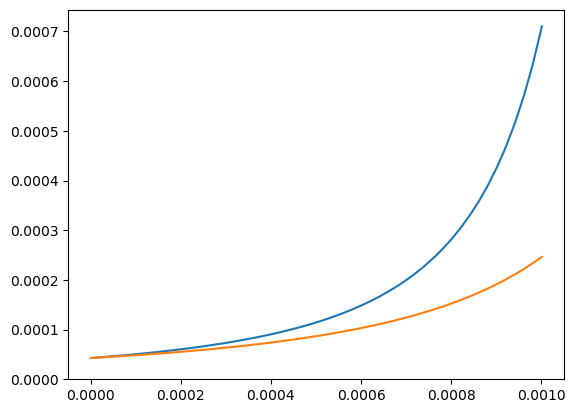

In [6]:
plt.plot(all_beta, all_data)
plt.ylim(0,)

In [7]:
np.savez_compressed("08_Ds_Pred.npz", beta=all_beta, Ds=all_data)